# *Sinuosity* numerical exploration


## Python setup

In [1]:
import bedrockriver as br, sympy as sy, numpy as np, matplotlib.pyplot as plt
sy.init_printing(pretty_print=True,wrap_line=True)
from symbols import *

In [2]:
sm = br.sinuosity.bend_model()

In [3]:
sm.get_params()

## Numerical exploration

### Parameters

In [4]:
sm.reset_params()
sm.set_params(  {theta:sm.pi/4, Omega_r:10} )
sm.set_params(  {epsilon_r:0.1} )
sm.set_params(  {u_i:5,d_i:30} )

# sm.set_params(  {Q:30, beta_0:0.015} )
# w_range = (0.1,30)

# sm.set_params(  {Q:300, beta_0:0.0048} )
sm.set_params(  {Q:300, beta_0:0.0015} )
w_range = (0.1,100)

sm.set_params(  {Q:3000, beta_0:0.0015} )
w_range = (0.1,300)

sm.get_params()
chi_range=(0,3)
sm.specify_u_polynomial_constants({w:w,chi:chi})
sm.specify_d_polynomial_constants({w:w,chi:chi})
res = 30

w_vec,chi_vec,w_mesh,chi_mesh \
  = sm.create_w_chi_vecs_meshes(w_range,chi_range,res=res)
sm.u_i, sm.d_i

### Hydraulics

In [5]:
# chi_list, wud_vec_list = sm.u_d_for_w_chi(res=30)

In [6]:
# sinuosity.plot.plot_u_w(sm, chi_list, wud_vec_list)
# sinuosity.plot.plot_d_w(sm, chi_list, wud_vec_list)
# sinuosity.plot.plot_u_d(sm, chi_list, wud_vec_list)

In [7]:
u_array,d_array = sm.nsolve_scipy_u_d_for_w_chi_meshes(w_mesh,chi_mesh)
epsilon_array = sm.epsilon_wrap_for_w_chi_meshes(w_mesh,chi_mesh,d=d_array)

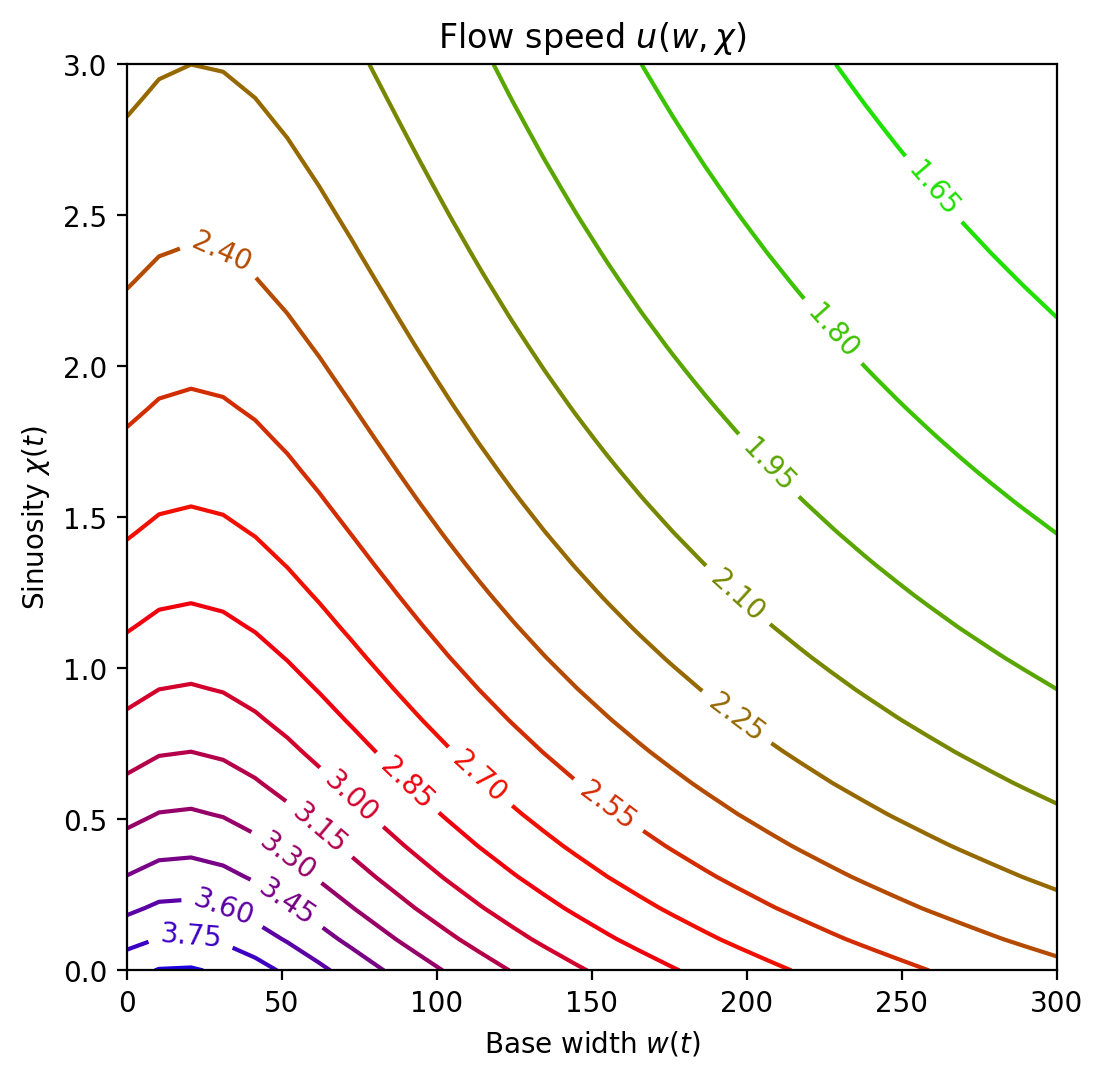

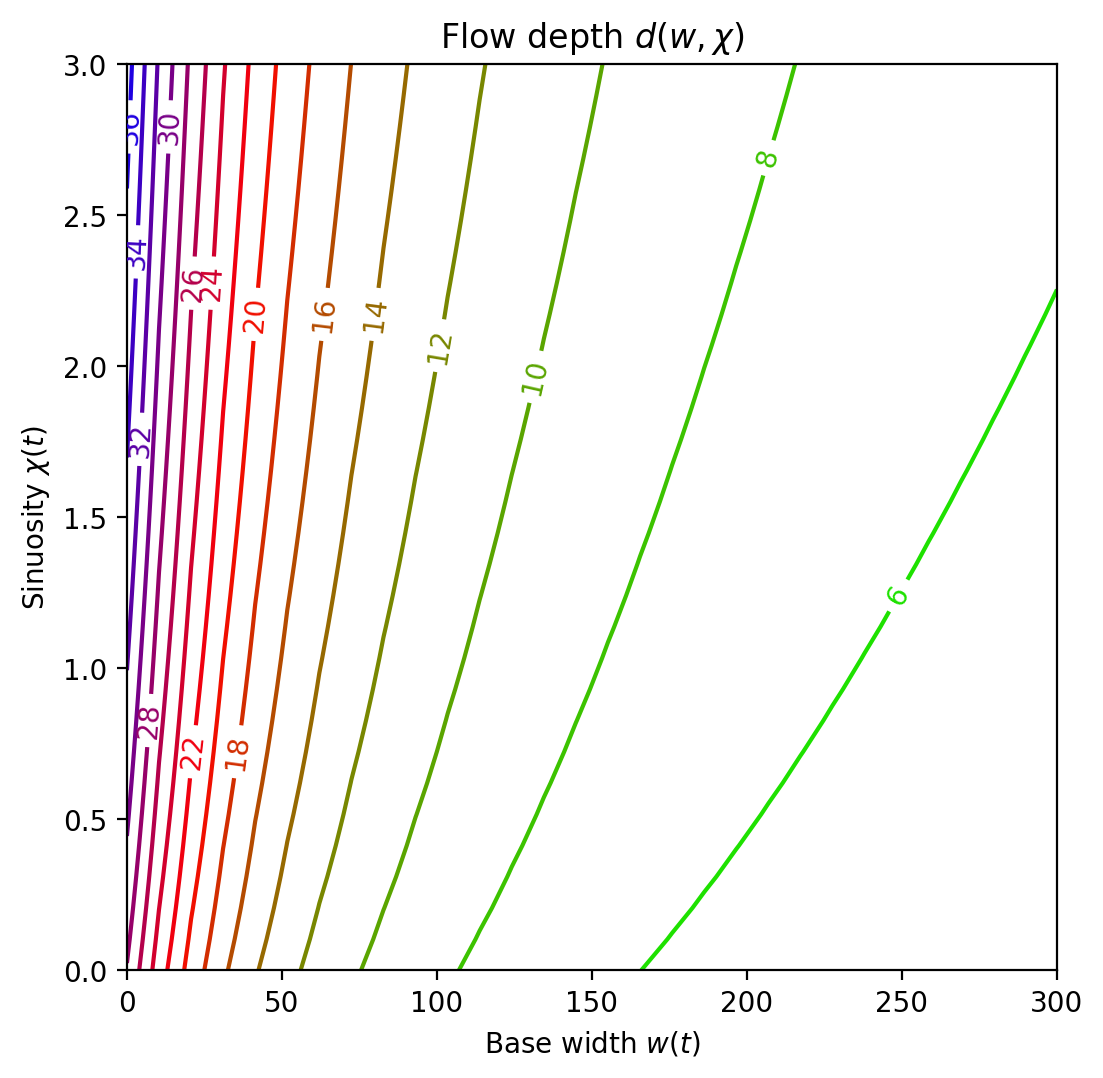

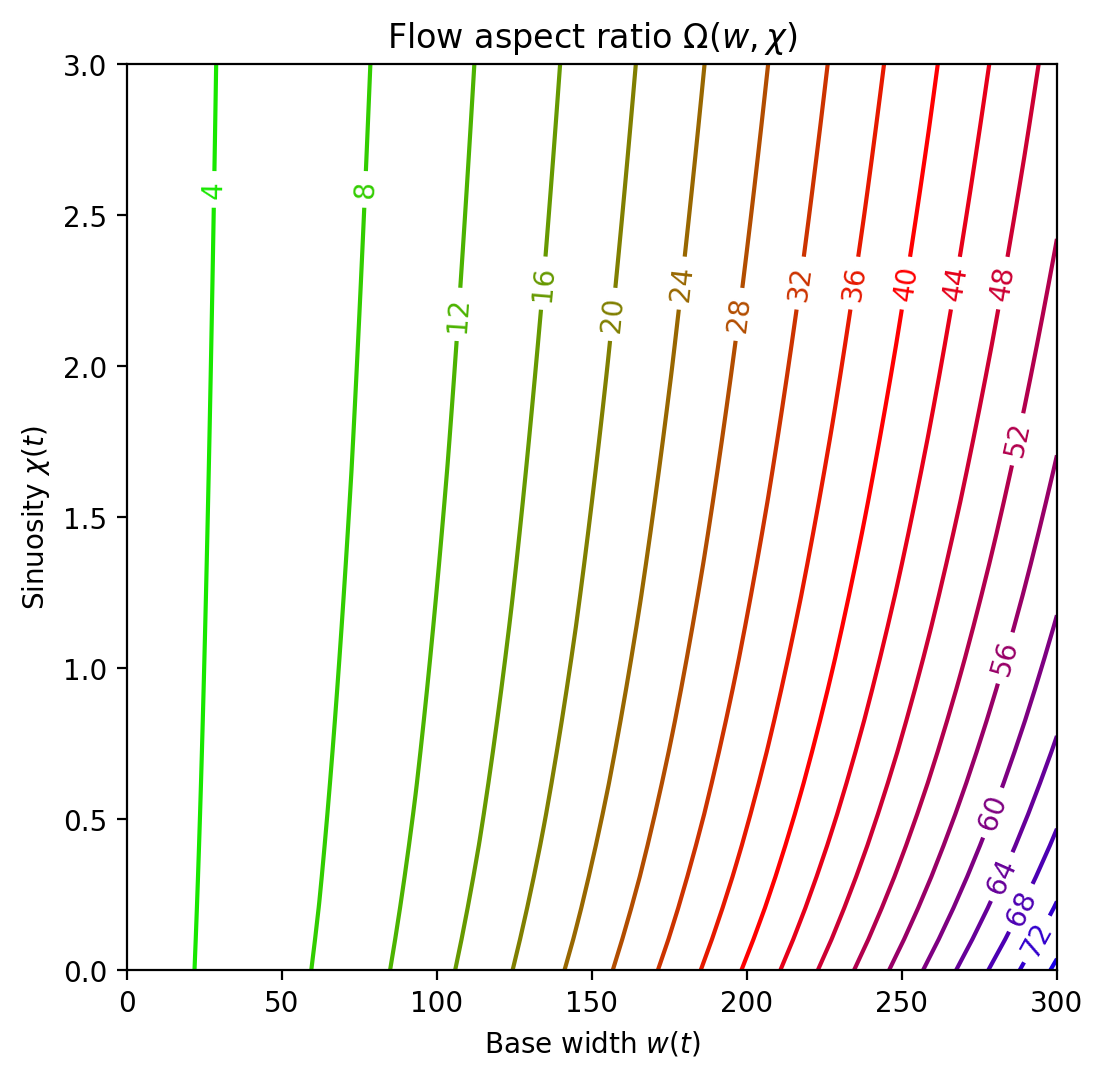

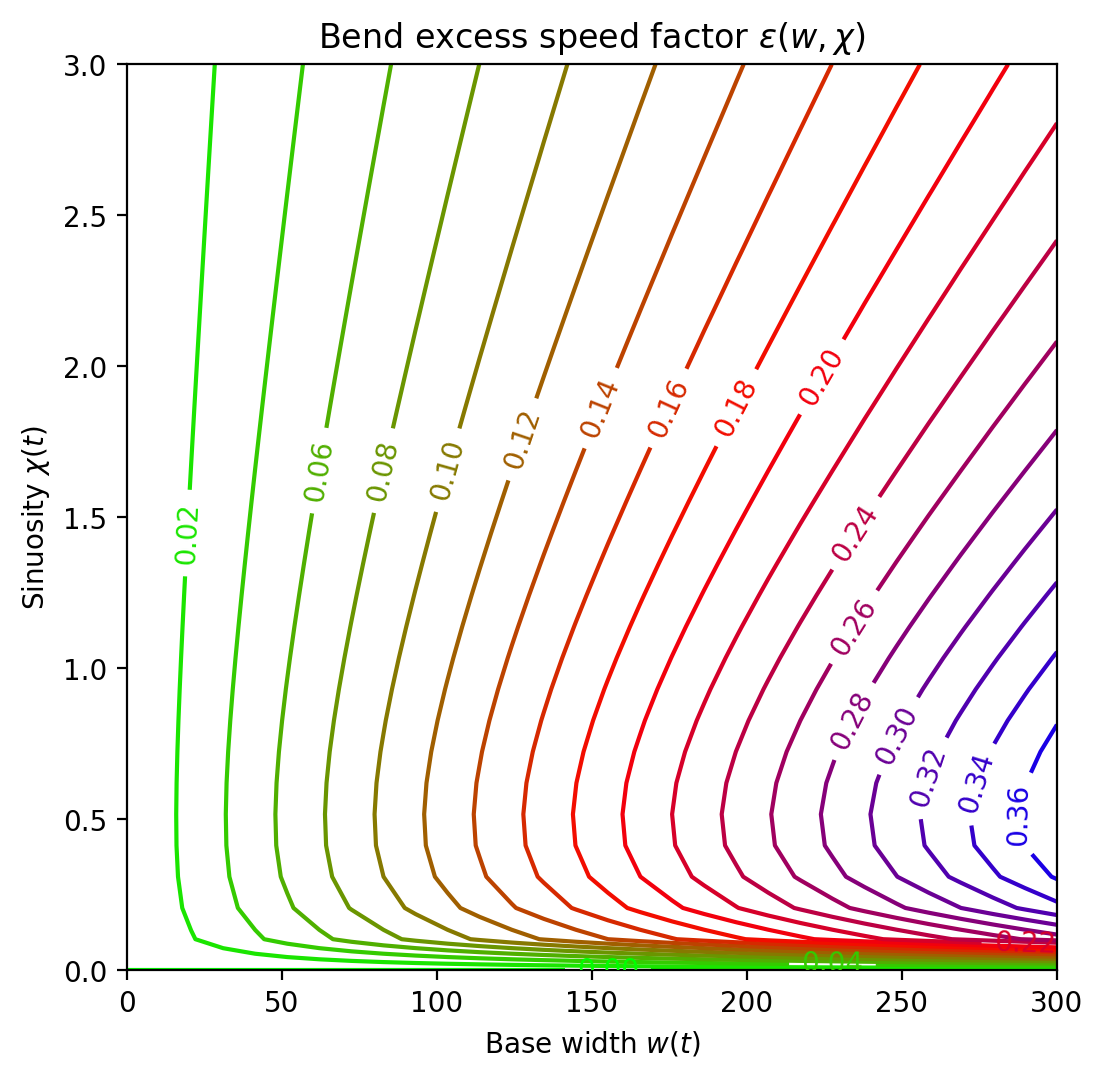

In [8]:
title='Flow speed $u(w, \\chi)$'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, 
                                      u_array,
#                                       u_interp(w_array,chi_array),
                                      title=title,
                                      fig_name='contour_u_from_w_chi', 
                                      fmt='%1.2f')

title='Flow depth $d(w, \\chi)$'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, 
                                      d_array,
#                                       d_interp(w_array,chi_array),
                                      title=title,
                                      fig_name='contour_d_from_w_chi', 
                                      fmt='%1.0f')

from numpy import sqrt,sin,float32
title='Flow aspect ratio $\\Omega(w, \\chi)$'
Omega_array = (w_mesh+2*d_array/sin(float32(sm.theta)))/d_array
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, 
                                  Omega_array,
#                                       d_interp(w_array,chi_array),
                                  title=title,
                                  fig_name='contour_Omega_from_w_chi', 
                                  fmt='%1.0f')
sf=1
title='Bend excess speed factor $\\epsilon(w, \\chi)$'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, 
                                  epsilon_array,
                                  title=title, 
                                  fig_name='contour_epsilon_from_w_chi', 
                                  sf=sf, fmt='%1.2f')

### Channel change rates

In [9]:
sm.set_params(  {mu:1.0,eta:2} )
sm.get_params()
xiz_array       = sm.xiz_for_u(u_array)
xiy_plus_array  = sm.xiy_for_u_d_epsilon_w(u_array,d_array,
                                           epsilon_array,w_mesh,+1)
xiy_minus_array = sm.xiy_for_u_d_epsilon_w(u_array,d_array,
                                           epsilon_array,w_mesh,-1)

# tanphi_plus_array  = sm.tanphi_xiz_xiy(xiz_array, xiy_plus_array)
# tanphi_minus_array = sm.tanphi_xiz_xiy(xiz_array, xiy_minus_array)

dcdt_plus_array  = sm.dcdt_for_xiz_xiy(xiz_array, xiy_plus_array)
dcdt_minus_array = sm.dcdt_for_xiz_xiy(xiz_array, xiy_minus_array)

dwdt_array = sm.dwdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
dmdt_array = sm.dmdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
dchidt_array = sm.dchidt_for_dmdt(dmdt_array)

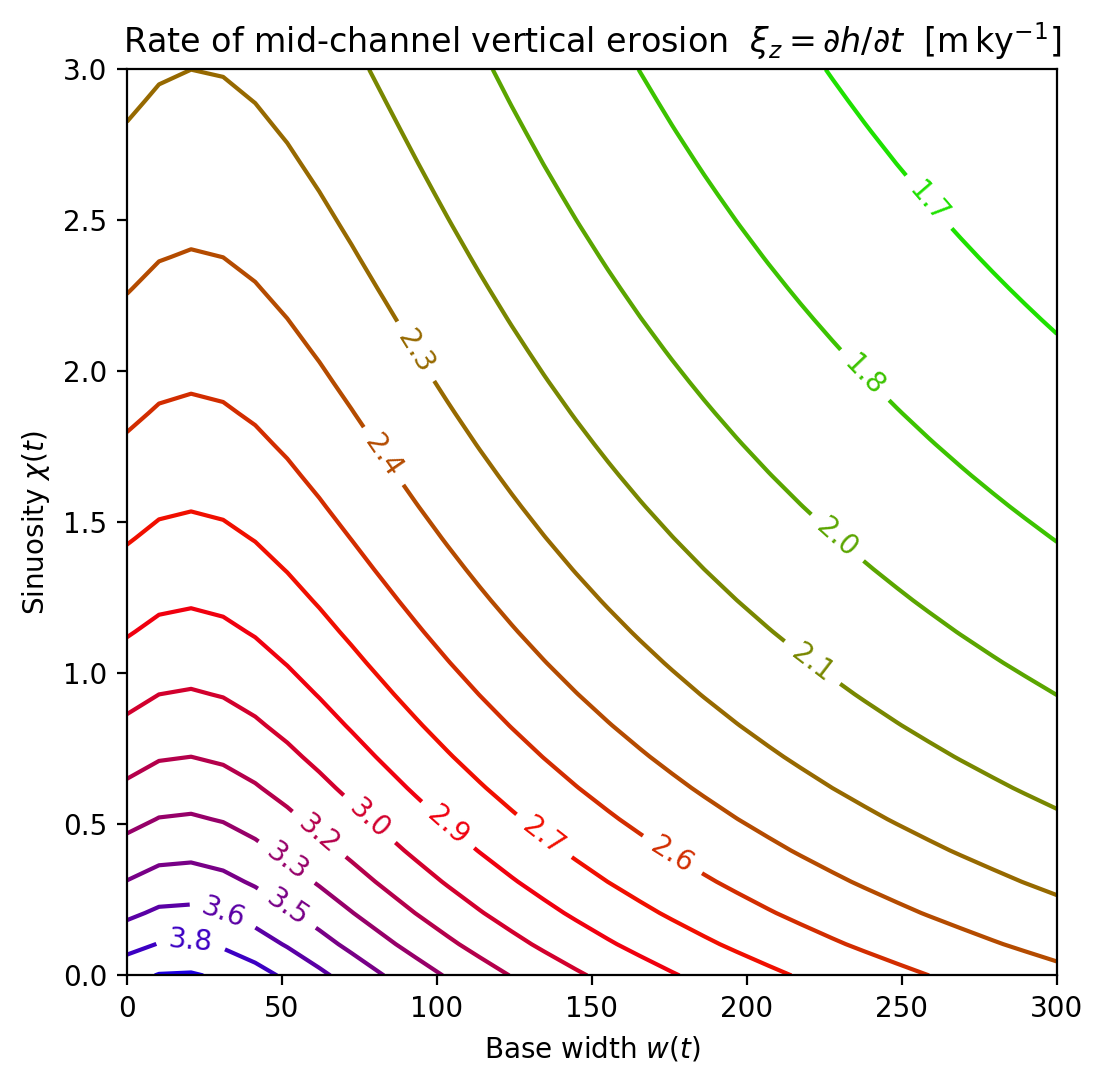

In [10]:
title = 'Rate of mid-channel vertical erosion  ' \
        + '$\\xi_z=\\partial{h}/\\partial{t}$' \
        + '  [m$\,$ky$^{-1}$]'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, xiz_array,
                                  title=title, 
                                  fig_name='contour_dhdt_from_w_chi', 
                                  sf=1, fmt='%1.1f', 
                                  do_plot_contours=True)

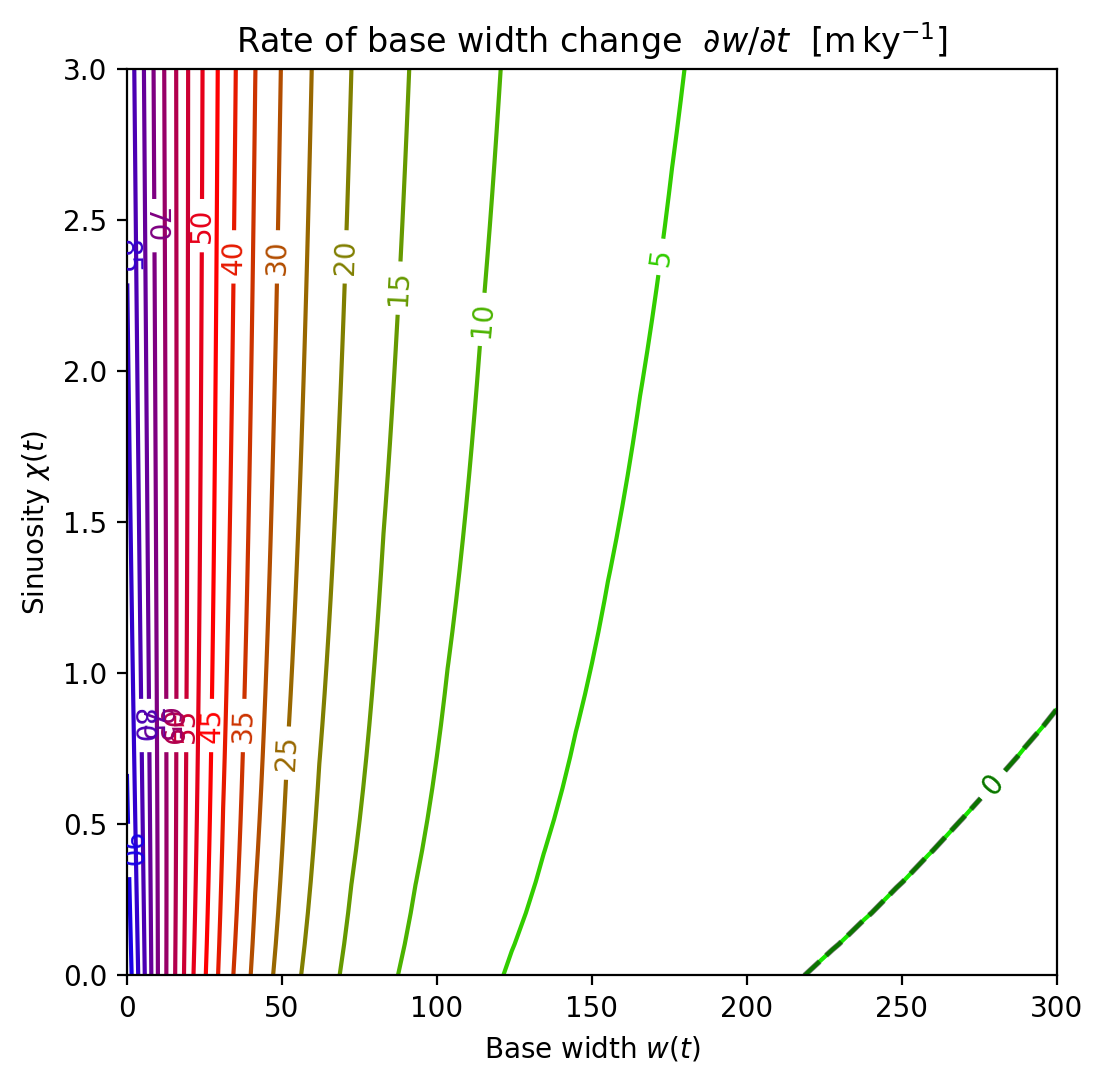

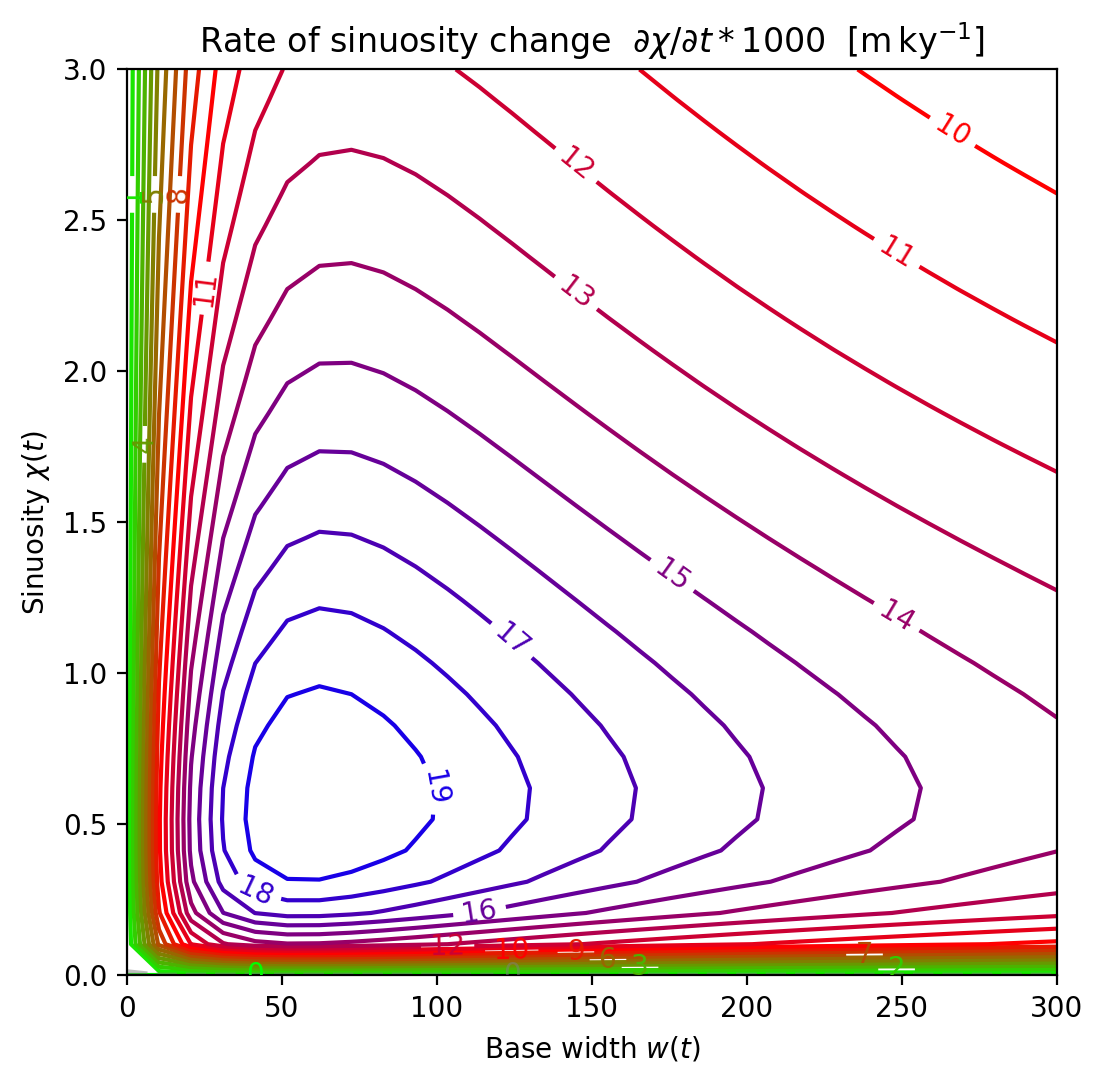

In [11]:
title = 'Rate of base width change  $\\partial{w}/\\partial{t}$' \
        + '  [m$\,$ky$^{-1}$]'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, dwdt_array,
                                  title=title, 
                                  fig_name='contour_dwdt_from_w_chi', 
                                  sf=1, fmt='%1.0f', 
                                  fat_line=[0.0,'k',True,2,0.5,'dashed'],
                                  do_plot_contours=True)
sf=sm.L
#         + '{0}'.format(Decimal(str(sf)).normalize())+'$' \
title='Rate of sinuosity change  $\\partial\\chi/\\partial{t}*' \
        + '{0}'.format(sf.round(0))+'$' \
        + '  [m$\,$ky$^{-1}$]'
br.plot.contour_grid_for_w_chi(sm, w_vec, chi_vec, dchidt_array,
                              title=title, 
                              fig_name='contour_dchidt_from_w_chi', 
                              sf=sf, fmt='%1.0f', 
                              fat_line=[0.01,'gray',True,2,0.5,'dashed'])

### 3DOF evolution: $\{w,\chi,\beta_0\}(t)$

In [12]:
sm.reset_params()
sm.set_params(  {Q:250,mu:0.2,eta:2} )
sm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = sm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [13]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
sm.get_params({beta_0:None, Q:None})

array([[0.00000e+00, 5.00000e+01, 5.00000e-02, 1.00000e-03],
       [7.50000e+01, 3.95683e+01, 5.63000e-02, 1.50000e-03],
       [1.50000e+02, 2.99774e+01, 6.31000e-02, 1.90000e-03],
       [2.25000e+02, 2.42330e+01, 7.05000e-02, 2.30000e-03],
       [3.00000e+02, 2.15351e+01, 7.82000e-02, 2.70000e-03],
       [3.75000e+02, 2.00554e+01, 8.63000e-02, 3.00000e-03],
       [4.50000e+02, 1.90313e+01, 9.46000e-02, 3.30000e-03],
       [5.25000e+02, 1.82372e+01, 1.03200e-01, 3.60000e-03],
       [6.00000e+02, 1.75921e+01, 1.12000e-01, 3.90000e-03],
       [6.75000e+02, 1.70543e+01, 1.21100e-01, 4.10000e-03],
       [7.50000e+02, 1.65966e+01, 1.30300e-01, 4.40000e-03],
       [8.25000e+02, 1.62035e+01, 1.39800e-01, 4.60000e-03],
       [9.00000e+02, 1.58671e+01, 1.49400e-01, 4.90000e-03],
       [9.75000e+02, 1.55695e+01, 1.59200e-01, 5.10000e-03],
       [1.05000e+03, 1.53040e+01, 1.69200e-01, 5.30000e-03],
       [1.12500e+03, 1.50680e+01, 1.79200e-01, 5.50000e-03],
       [1.20000e+03, 1.4

In [14]:
sm.reset_params()
sm.set_params(  {Q:3000,mu:1,eta:2} )
sm.get_params()
w_range = (0.1,300)
import numpy as np
(ode_integrations_list, t_w_chi_beta0_vecs_list, 
 w_chi_beta0_interp_as_t_list, t_w_chi_beta0_resampled_vecs_list) \
  = sm.ode_integrate_w_chi_beta0(t_span=[0.0,1500],
                                 initial_state=np.array([50,0.05,0.001]))

In [15]:
t_w_chi_beta0_resampled_vecs_list.round(4)
np.mean(t_w_chi_beta0_resampled_vecs_list[:,3])
sm.get_params({beta_0:5, Q:None})
sm.get_params()

array([[0.000000e+00, 5.000000e+01, 5.000000e-02, 1.000000e-03],
       [7.500000e+01, 3.361739e+02, 1.065900e+00, 4.000000e-04],
       [1.500000e+02, 4.485633e+02, 1.858700e+00, 5.000000e-04],
       [2.250000e+02, 5.205603e+02, 2.462900e+00, 6.000000e-04],
       [3.000000e+02, 5.712727e+02, 2.965400e+00, 7.000000e-04],
       [3.750000e+02, 6.089038e+02, 3.403800e+00, 8.000000e-04],
       [4.500000e+02, 6.377787e+02, 3.798000e+00, 9.000000e-04],
       [5.250000e+02, 6.603850e+02, 4.159400e+00, 1.100000e-03],
       [6.000000e+02, 6.781765e+02, 4.494700e+00, 1.200000e-03],
       [6.750000e+02, 6.922296e+02, 4.809000e+00, 1.300000e-03],
       [7.500000e+02, 7.032362e+02, 5.105300e+00, 1.400000e-03],
       [8.250000e+02, 7.120845e+02, 5.387800e+00, 1.500000e-03],
       [9.000000e+02, 7.191171e+02, 5.658200e+00, 1.600000e-03],
       [9.750000e+02, 7.246092e+02, 5.917700e+00, 1.700000e-03],
       [1.050000e+03, 7.288984e+02, 6.167800e+00, 1.800000e-03],
       [1.125000e+03, 7.3

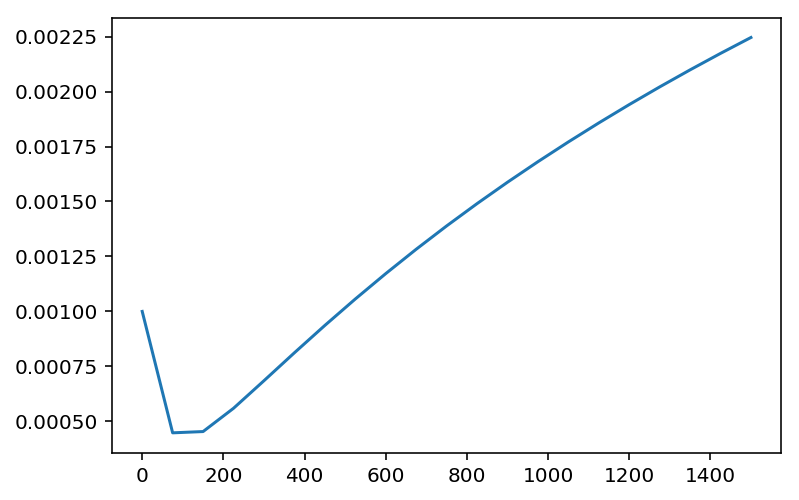

In [16]:
plt.plot(t_w_chi_beta0_resampled_vecs_list[:,0],
         t_w_chi_beta0_resampled_vecs_list[:,3]);

### Channel evolution

In [17]:
# sm.set_params(  {Q:1000, beta_0:0.003, mu:5} )
# t_span=[0.0,3e2]
# sm.get_params()

# res = 10
# w_vec,chi_vec,w_mesh,chi_mesh = sm.create_w_chi_vecs_meshes(w_range,chi_range,res=res)
# u_array,d_array = sm.nsolve_scipy_u_d_for_w_chi_meshes(w_mesh,chi_mesh)
# epsilon_array = sm.epsilon_wrap_for_w_chi_meshes(w_mesh,chi_mesh)

# xiz_array       = sm.xiz_for_u(u_array)
# xiy_plus_array  = sm.xiy_for_u_d_epsilon_w(u_array,d_array,epsilon_array,w_mesh,+1)
# xiy_minus_array = sm.xiy_for_u_d_epsilon_w(u_array,d_array,epsilon_array,w_mesh,-1)
# dcdt_plus_array  = sm.dcdt_for_xiz_xiy(xiz_array, xiy_plus_array)
# dcdt_minus_array = sm.dcdt_for_xiz_xiy(xiz_array, xiy_minus_array)
# dwdt_array = sm.dwdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
# dmdt_array = sm.dmdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
# dchidt_array = sm.dchidt_for_dmdt(dmdt_array)

# sm.perform_ode_integrations(t_span=t_span, interp_t_step=1,
#                             n_solutions=1, 
#                             initial_w_range=[50,300],
#                             initial_chi_range=[0.01,0.5],
#                             random_seed=1, do_densify=False, 
#                             interp_kind='cubic')
# sm.t_w_chi_means_array

In [18]:
# from decimal import Decimal
# title =   '$Q=${0}'.format(sm.Q.round(0))+' m$^3\,$s$^{-1}$' \
#         + '   $\\beta_0=${0}'.format(Decimal(str(sm.beta_0)).normalize()) \
#         + '   $\mu=${0}'.format(sm.mu.round(0))
# sinuosity.plot.quiver_grids_for_w_chi(
#         sm, w_mesh, chi_mesh, 
#         dwdt_array, dchidt_array,
#         title=title, 
#         fig_name='quiver_dwchidt_from_w_chi',
#         scale=6, 
#         do_channel_line=True,
#         ode_integrations=sm.t_w_chi_vecs_list,
#         ode_interps=sm.w_chi_interp_as_t_list,
#         ode_resamples=sm.t_w_chi_resampled_vecs_array,
#         n_interp_pts=300
#     )

In [19]:
# sm.set_params(  {Q:1000, beta_0:0.001, mu:5*3**3} )
# t_span=[0.0,3e2]
# sm.get_params()

# res = 10
# w_vec,chi_vec,w_mesh,chi_mesh = sm.create_w_chi_vecs_meshes(w_range,chi_range,res=res)
# u_array,d_array = sm.nsolve_scipy_u_d_for_w_chi_meshes(w_mesh,chi_mesh)
# epsilon_array = sm.epsilon_wrap_for_w_chi_meshes(w_mesh,chi_mesh)

# xiz_array       = sm.xiz_for_u(u_array)
# xiy_plus_array  = sm.xiy_for_u_d_epsilon_w(u_array,d_array,epsilon_array,w_mesh,+1)
# xiy_minus_array = sm.xiy_for_u_d_epsilon_w(u_array,d_array,epsilon_array,w_mesh,-1)
# dcdt_plus_array  = sm.dcdt_for_xiz_xiy(xiz_array, xiy_plus_array)
# dcdt_minus_array = sm.dcdt_for_xiz_xiy(xiz_array, xiy_minus_array)
# dwdt_array = sm.dwdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
# dmdt_array = sm.dmdt_for_dcdt(dcdt_plus_array,dcdt_minus_array)
# dchidt_array = sm.dchidt_for_dmdt(dmdt_array)

# sm.perform_ode_integrations(t_span=t_span, interp_t_step=1,
#                             n_solutions=1, 
#                             initial_w_range=[50,300],
#                             initial_chi_range=[0.01,0.5],
#                             random_seed=1, do_densify=False, 
#                             interp_kind='cubic')
# sm.t_w_chi_means_array

In [20]:
# from decimal import Decimal
# title =   '$Q=${0}'.format(sm.Q.round(0))+' m$^3\,$s$^{-1}$' \
#         + '   $\\beta_0=${0}'.format(Decimal(str(sm.beta_0)).normalize()) \
#         + '   $\mu=${0}'.format(sm.mu.round(0))
# sinuosity.plot.quiver_grids_for_w_chi(
#         sm, w_mesh, chi_mesh, 
#         dwdt_array, dchidt_array,
#         title=title, 
#         fig_name='quiver_dwchidt_from_w_chi',
#         scale=6, 
#         do_channel_line=True,
#         ode_integrations=sm.t_w_chi_vecs_list,
#         ode_interps=sm.w_chi_interp_as_t_list,
#         ode_resamples=sm.t_w_chi_resampled_vecs_array,
#         n_interp_pts=300
#     )

Computing grids at resolution 25x25... done
Computing ODE trajectories... done


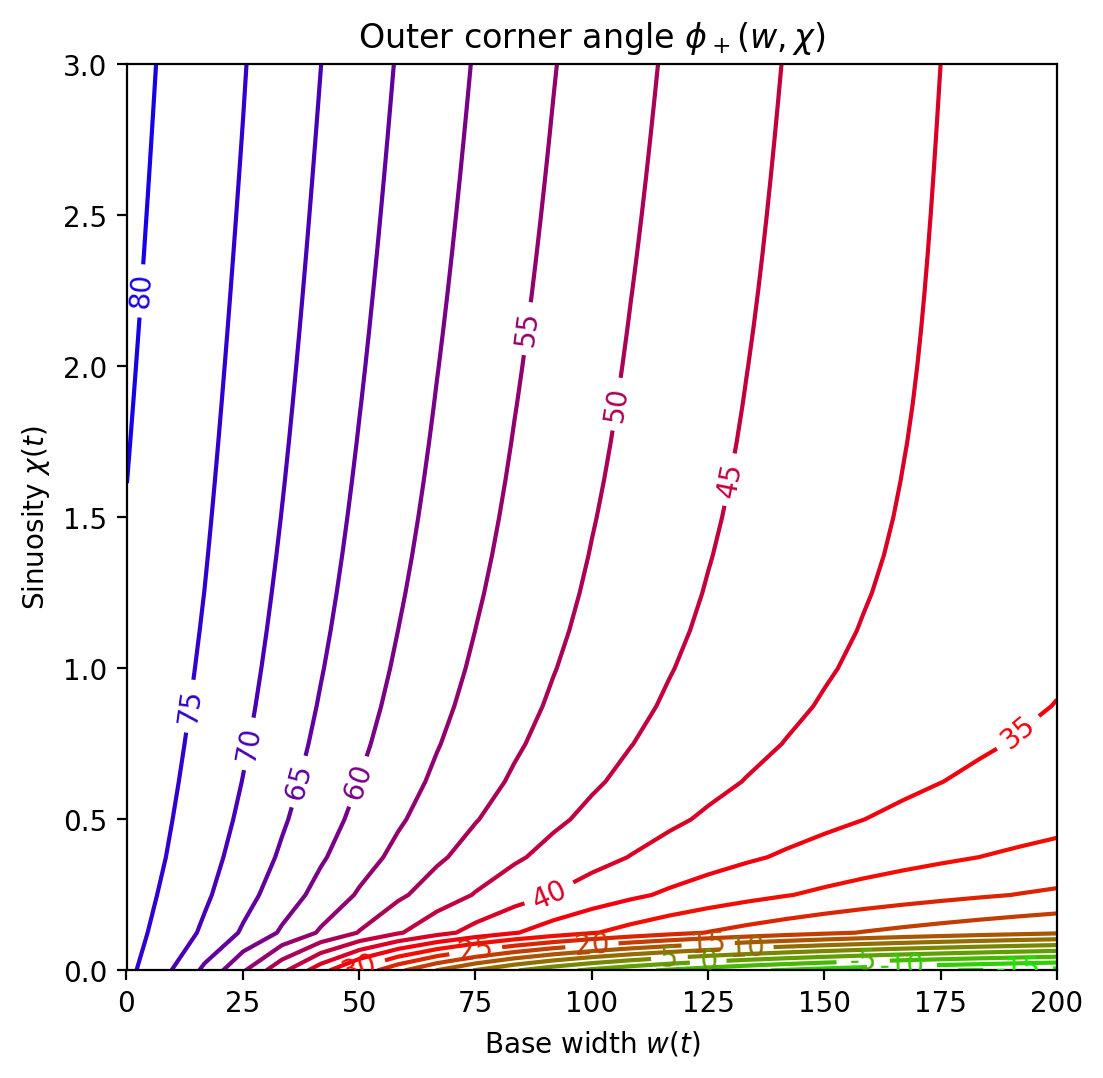

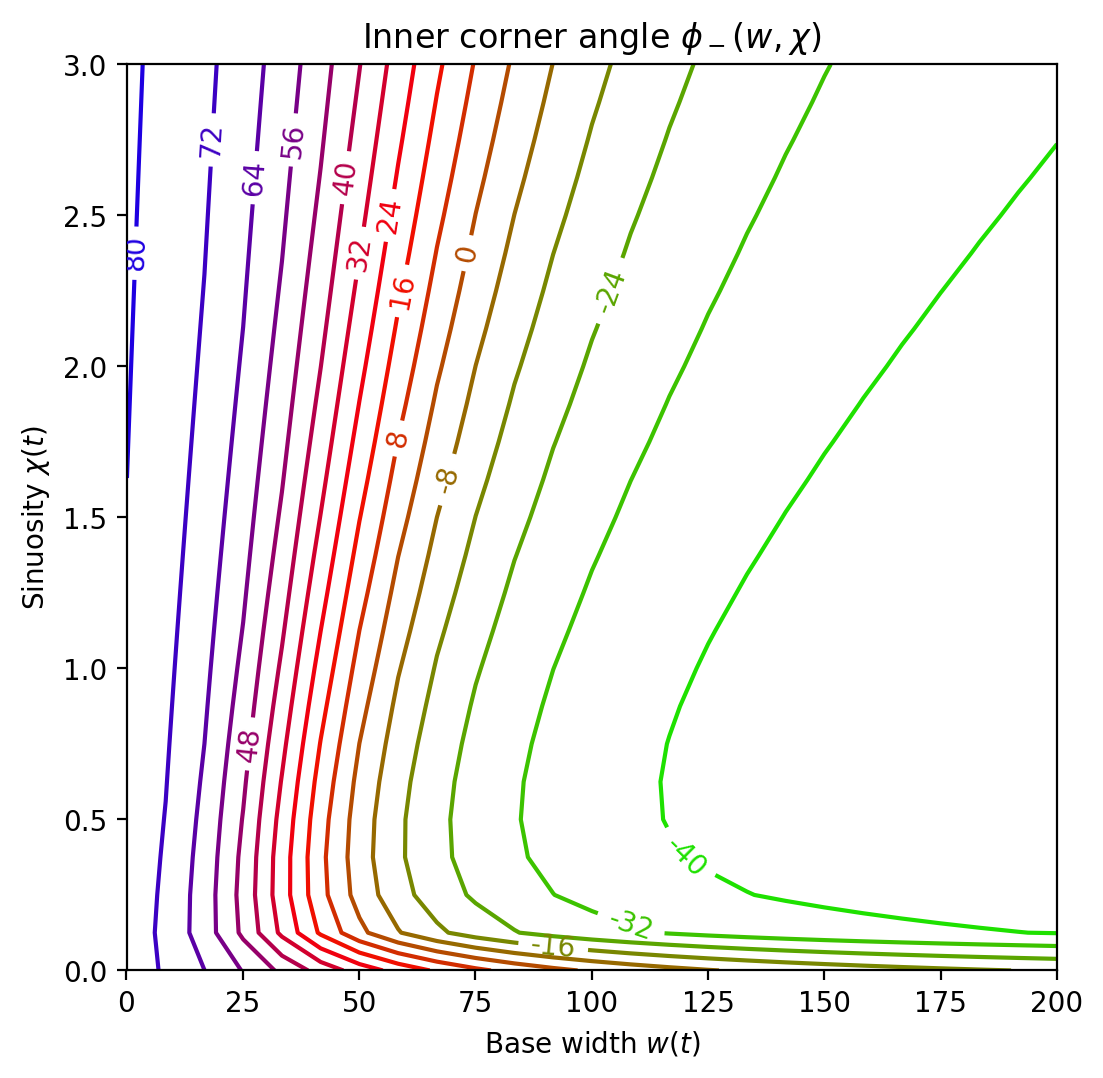

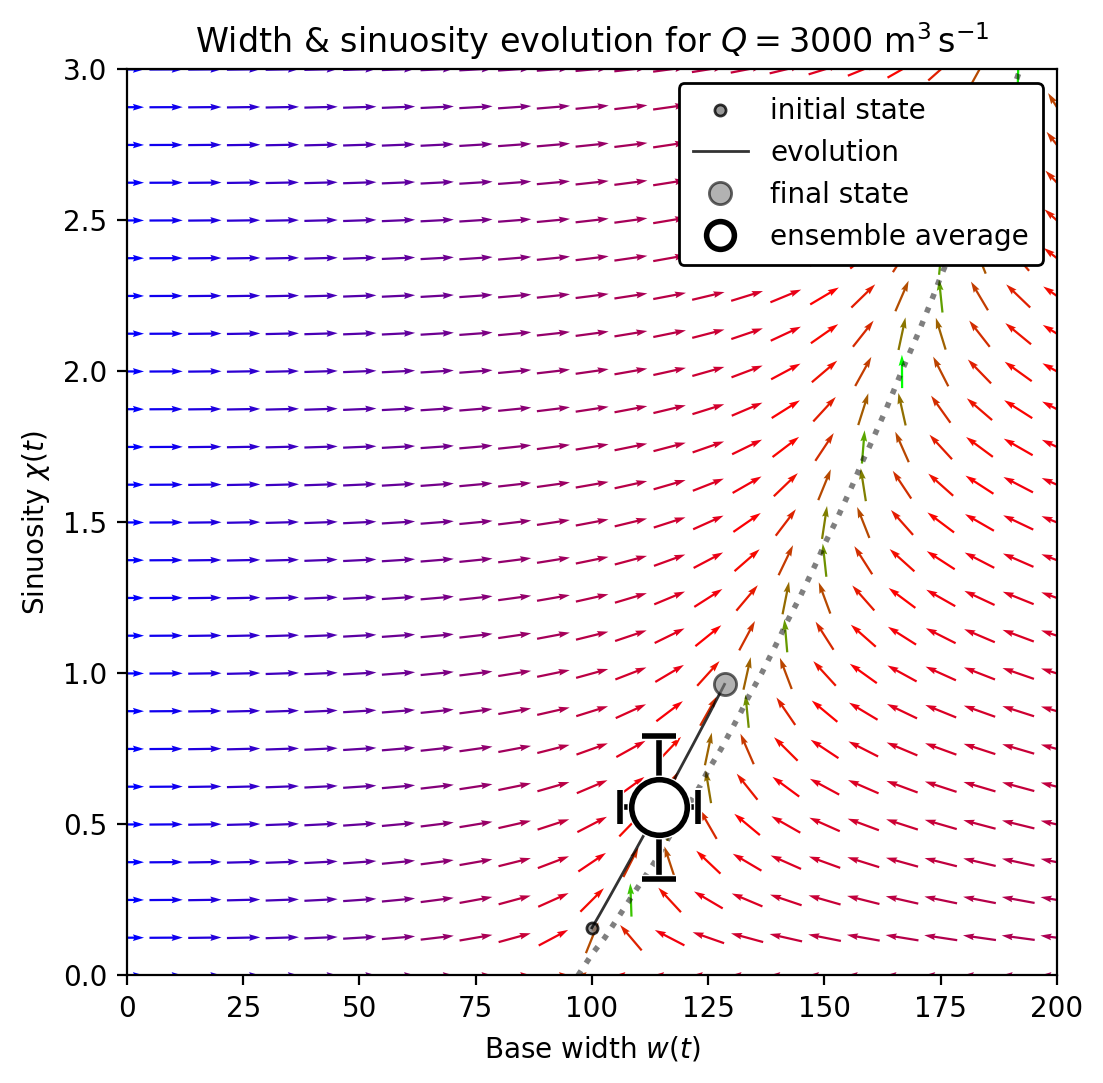

In [21]:
sm.reset_params()
Q_x = 3000
res = 25
sm.set_params(  {Q:Q_x, beta_0:0.001,mu:0.2} )
ss = br.ensemble.set(sm=sm, Q_range=(Q_x,Q_x))
sm.get_params()
ss.solve_combo_w_chi(0, t_span=[0.0,1e3], 
                     n_solutions=1, Q_x=Q_x, res=res,
                     initial_w_range=(100,100))
title='Outer corner angle $\\phi_+(w,\\chi)$'
br.plot.contour_grid_for_w_chi(sm, ss.w_vec_list[0], 
                                      ss.chi_vec_list[0], 
                                      ss.tanphi_plus_array_list[0], 
                                      is_tanphi=True,
                                      title=title,
                              fig_name='contour_tanphiplus_from_w_chi', 
                                      fmt='%1.0f')
title='Inner corner angle $\\phi_-(w,\\chi)$'
br.plot.contour_grid_for_w_chi(sm, ss.w_vec_list[0], 
                                      ss.chi_vec_list[0], 
                                      ss.tanphi_minus_array_list[0], 
                                      is_tanphi=True,
                                      title=title,
                              fig_name='contour_tanphiminus_from_w_chi', 
                                      fmt='%1.0f')
br.plot.ensemble_chi_w_for_t(sm,ss)

Computing grids at resolution 25x25... done
Computing ODE trajectories... done


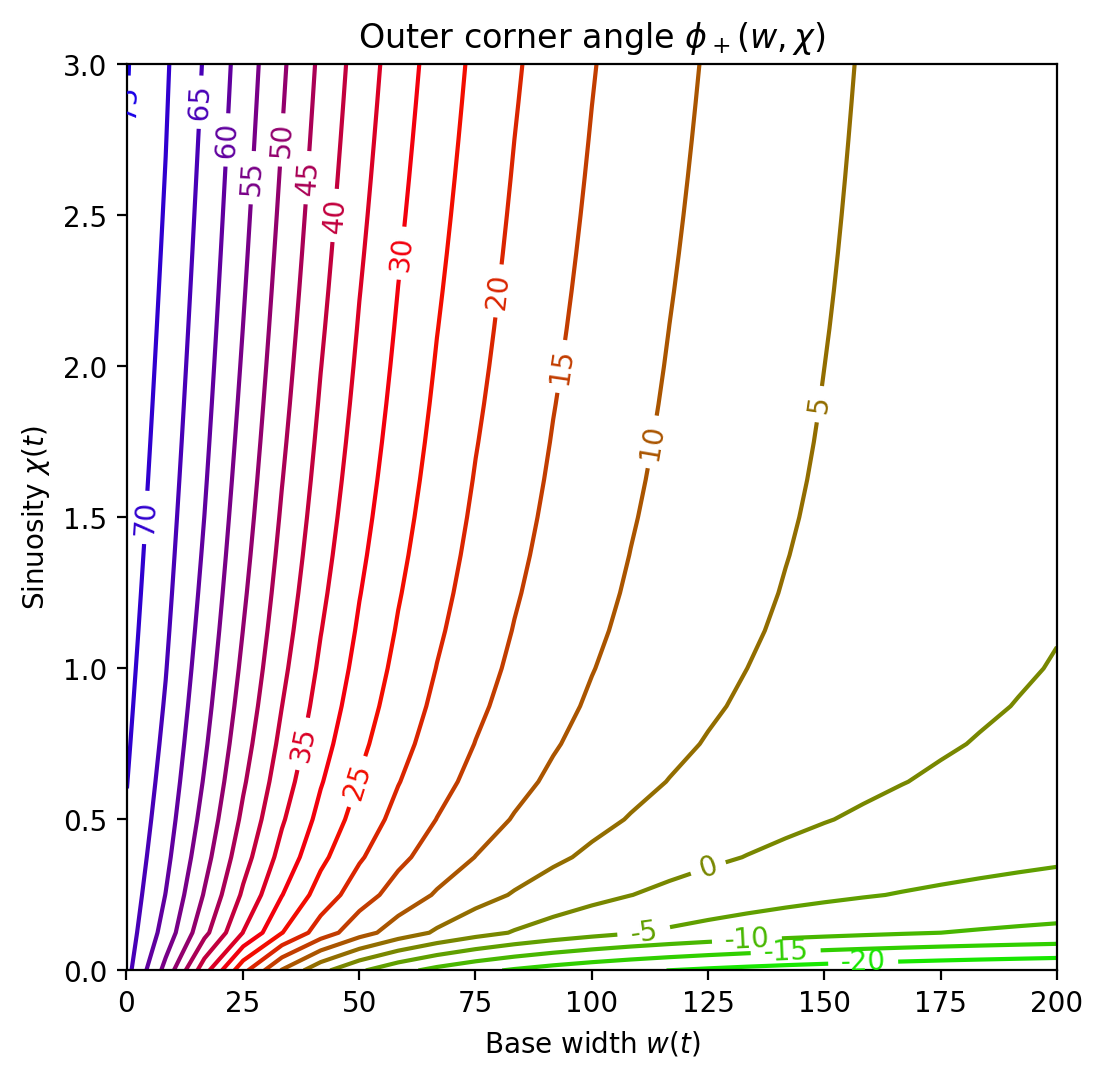

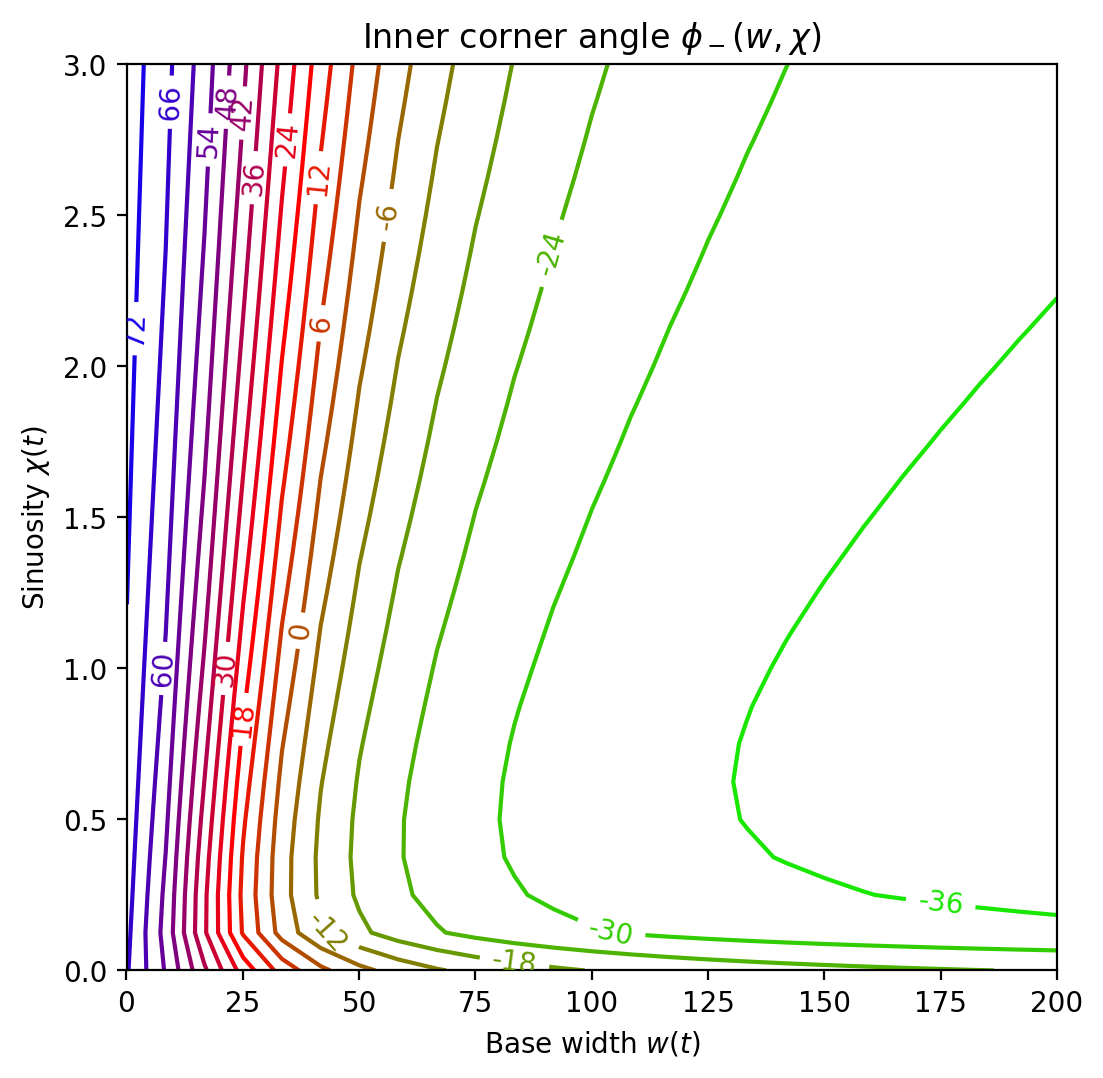

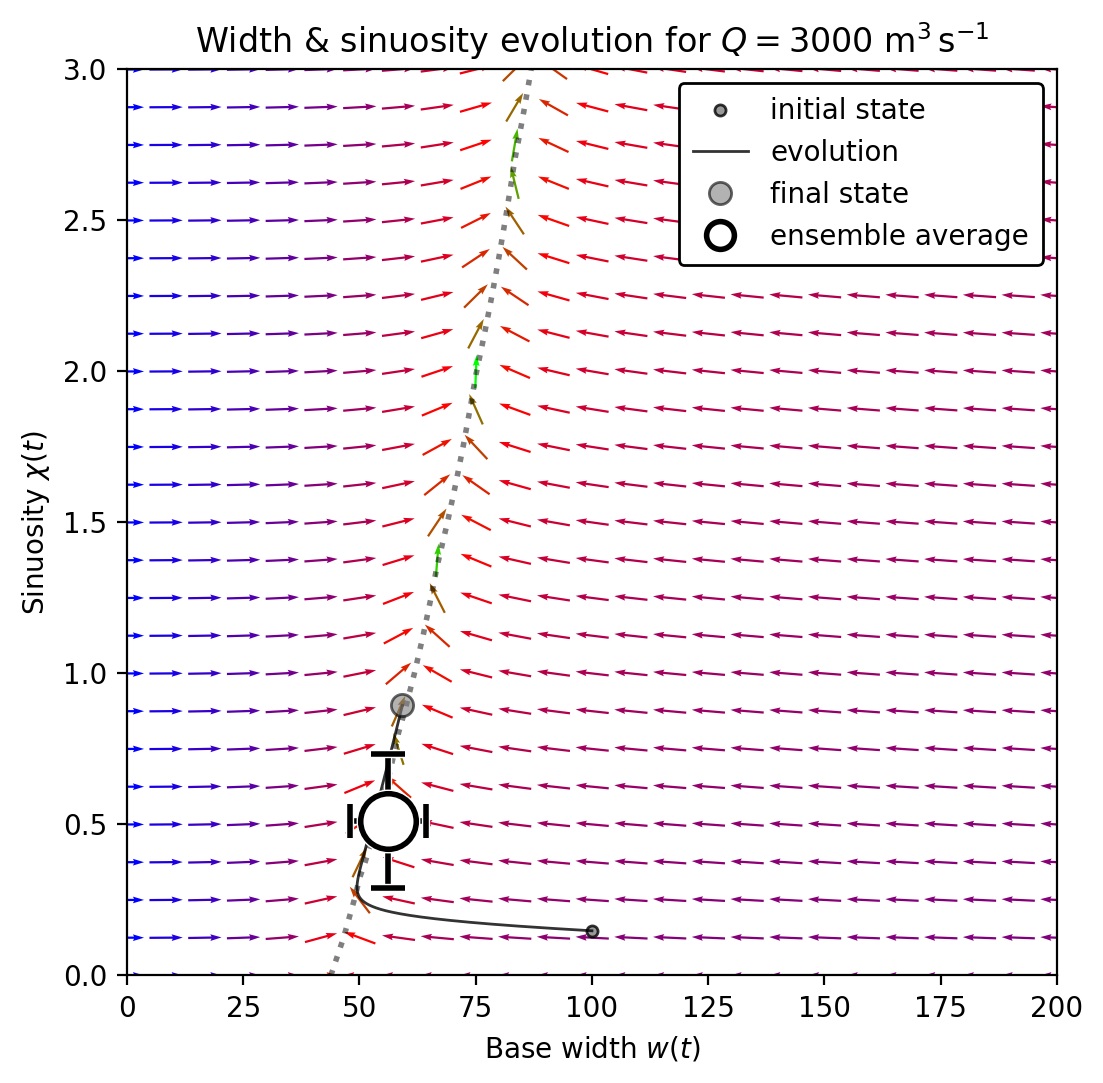

In [22]:
sm.reset_params()
Q_x = 3000
res = 25
sm.set_params(  {Q:Q_x, beta_0:0.005,mu:0.2} )
ss = br.ensemble.set(sm=sm, Q_range=(Q_x,Q_x))
sm.get_params()
ss.solve_combo_w_chi(0, t_span=[0.0,1e3], 
                     n_solutions=1, Q_x=Q_x, res=res,
                     initial_w_range=(100,100))
title='Outer corner angle $\\phi_+(w,\\chi)$'
br.plot.contour_grid_for_w_chi(sm, ss.w_vec_list[0], 
                                      ss.chi_vec_list[0], 
                                      ss.tanphi_plus_array_list[0], 
                                      is_tanphi=True,
                                      title=title,
                              fig_name='contour_tanphiplus_from_w_chi', 
                                      fmt='%1.0f')
title='Inner corner angle $\\phi_-(w,\\chi)$'
br.plot.contour_grid_for_w_chi(sm, ss.w_vec_list[0], 
                                      ss.chi_vec_list[0], 
                                      ss.tanphi_minus_array_list[0], 
                                      is_tanphi=True,
                                      title=title,
                              fig_name='contour_tanphiminus_from_w_chi', 
                                      fmt='%1.0f')
br.plot.ensemble_chi_w_for_t(sm,ss)